In [1]:
import numpy as np
from scipy.io import loadmat
import networkx as nx
import matplotlib.pyplot as plt 
import itertools
from scipy.stats import norm
import math
import pingouin as pg
import pandas as pd

### Load data

In [2]:
def load_data(path = "Data.mat",column = 'D') :
    
    data = loadmat(path)[column]
    return data

In [3]:
data = load_data()
print(data.shape)

# default value
alpha = 0.05

(10000, 8)


###  (1) Complete undirected graph

In [4]:
def complete_undirected_graph(D, save = False) :
    
    # get the number of RVs and sample
    P = data.shape[1]
    nb_sample = data.shape[0]
    
    # Adjacency matrix
    V_adjacency = np.ones((P,P))
    # no self connection
    np.fill_diagonal(V_adjacency, 0)
    
    # complete undirected graph
    G_undirected = nx.from_numpy_matrix(V_adjacency)
    nx.draw_networkx(G_undirected, with_labels=True)
    
    if save : 
        plt.axis('off')
        plt.savefig("undirected_graph.png") # save as png
        plt.show() # display
    
    return G_undirected,V_adjacency,P,nb_sample

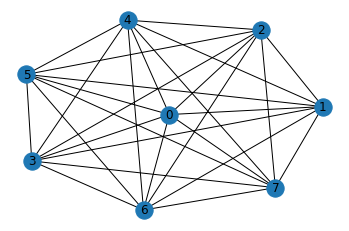

In [5]:
_ ,_,_,_ = complete_undirected_graph(data,True)

### (2) Conditional independence tests

In [6]:
def make_skeleton(D,alpha) :
    
    # plot the complete undirected graph
    plt.figure(figsize = (15,6))
    plt.subplot(121)
    G_undirected,V_adjacency,P,nb_sample = complete_undirected_graph(data)
    
    # data frame for correlation computation
    col = []
    for i in range(data.shape[1]):
        col.append(str(i))
    df = pd.DataFrame(D, columns=col)
    
    # combination of set s to control for partial correlation
    s_set = [[set() for i in range(P)] for j in range(P)]
    
    # loop over the number of variable to control
    for l in range(P) :
        # loop over all nodes
        for i in range(P):
            # loop over the remainning nodes for pairwise combination
            for j in range(i+1,P):
                adj_i = list(G_undirected.adj[i])
                # remove node j of the list to control
                if j in adj_i:
                    adj_i.remove(j)
                if len(adj_i) >= l:
                    for k in itertools.combinations(adj_i, l):
                        if nb_sample-len(k)-3 < 0:
                            break
                        # list for the input of partial_corr
                        s = []
                        for c in k: 
                            s.append(str(c))
                        # partial correlation estimation
                        r = pg.partial_corr(data=df, x=str(i), y=str(j),covar=s,method='spearman').round(3)['r']['spearman'] 
                        # test value threshold
                        t = norm.isf(1-alpha/2) / np.sqrt(nb_sample-np.abs(len(s))-3)
                        
                        # check if r is zero or not by comapring to t and store the s set
                        if np.abs(r) <= np.abs(t):
                            V_adjacency[i][j] = V_adjacency[j][i] = 0
                            s_set[i][j] |= set(k)
                            s_set[j][i] |= set(k)


    G_skeleton = nx.from_numpy_matrix(V_adjacency)
    plt.subplot(122)
    nx.draw_networkx(G_skeleton, with_labels=True)
    plt.show()
    
    return G_skeleton,V_adjacency,s_set,P

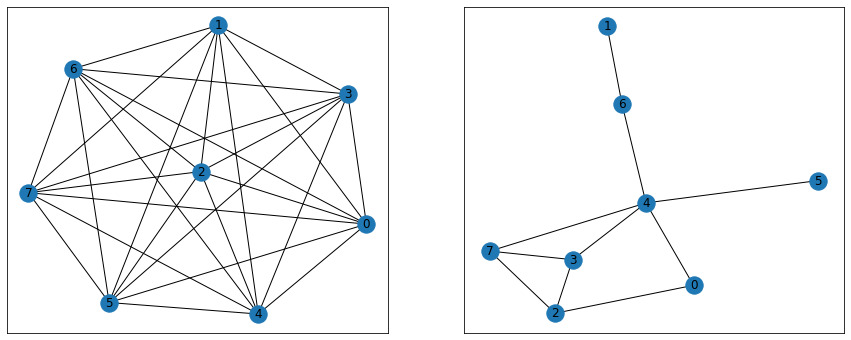

In [7]:
G_skeleton ,adj,s_set,P= make_skeleton(data,alpha)

### (3) Orient v-structures

In [8]:
def Orient_edges(D,alpha) :
    
    # get the skeleton
    G_skeleton ,adj,s_set,P= make_skeleton(D,alpha)
    
    # transform skeleton graph in directed graph
    G_directed =G_skeleton.to_directed()
    nodes = G_skeleton.nodes()
    
    # Statistical orientation -> collider
    for (i, j) in itertools.combinations(nodes, 2):
        adj_i = set(G_directed.successors(i))
        if j in adj_i:
            continue
        adj_j = set(G_directed.successors(j))
        if i in adj_j:
            continue
        if s_set[i][j] is None:
            continue
        shared_k = adj_i & adj_j
        for k in shared_k:
            if k not in s_set[i][j]:
                if G_directed.has_edge(k, i):
                    G_directed.remove_edge(k, i)
                if G_directed.has_edge(k, j):
                    G_directed.remove_edge(k, j)

    # meek rules iterating for all combination(i,j)
    for (i, j) in itertools.combinations(nodes, 2):
        # Rule 1: Orient i-j into i->j whenever there is an arrow k->i such that k and j are nonadjacent.
        if G_directed.has_edge(i, j) and G_directed.has_edge(j, i):
            # Look all the predecessors of i.
            for k in G_directed.predecessors(i):
                # abort if there is an arrow i->k.
                if G_directed.has_edge(i, k):
                    continue
                # abort if k and j are adjacent.
                if G_directed.has_edge(i, j) or G_directed.has_edge(j, i):
                    continue
                # orient i-j into i->j
                G_directed.remove_edge(j, i)

        # Rule 2: Orient i-j into i->j whenever there is a chain i->k->j.
        if G_directed.has_edge(i, j) and G_directed.has_edge(j, i):
            # Find nodes k where k is i->k.
            succs_i = set()
            for k in G_directed.successors(i):
                if not G_directed.has_edge(k, i):
                    succs_i.add(k)
            # Find nodes j where j is k->j.
            preds_j = set()
            for k in G_directed.predecessors(j):
                if not G_directed.has_edge(j, k):
                    preds_j.add(k)
            # Check if there is any node k where i->k->j.
            if len(succs_i & preds_j) > 0:
                # orient i-j into i->j
                G_directed.remove_edge(j, i)

        # Rule 3: Orient i-j into i->j whenever there are two chains i-k->j and i-l->j such that k and l are nonadjacent.
        if G_directed.has_edge(i, j) and G_directed.has_edge(j, i):
            # Find nodes k where i-k.
            adj_i = set()
            for k in G_directed.successors(i):
                if G_directed.has_edge(k, i):
                    adj_i.add(k)
            # For all the pairs of nodes in adj_i,
            for (k, l) in itertools.combinations(adj_i, 2):
                # abort if k and l are adjacent.
                if G_directed.has_edge(i, j) or G_directed.has_edge(j, i):
                    continue
                # abort if not k->j.
                if G_directed.has_edge(j, k) or (not G_directed.has_edge(k, j)):
                    continue
                # abort if not l->j.
                if G_directed.has_edge(j, l) or (not G_directed.has_edge(l, j)):
                    continue
                # orient i-j into i->j.
                G_directed.remove_edge(j, i)
    
    plt.figure(figsize = (15,8))
    nx.draw_networkx(G_directed,pos =nx.circular_layout(G_directed) , with_labels=True, arrows=True)

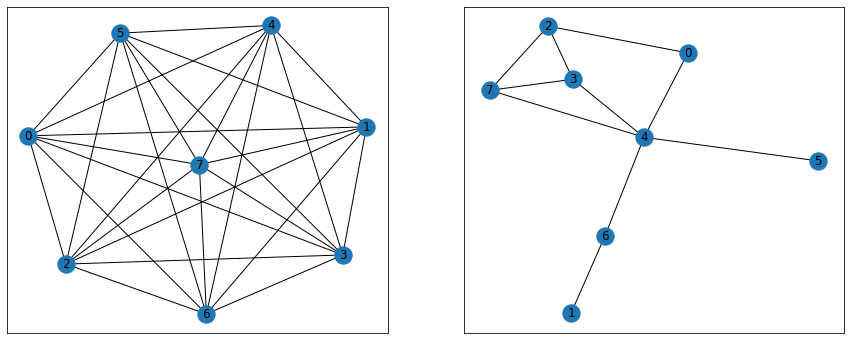

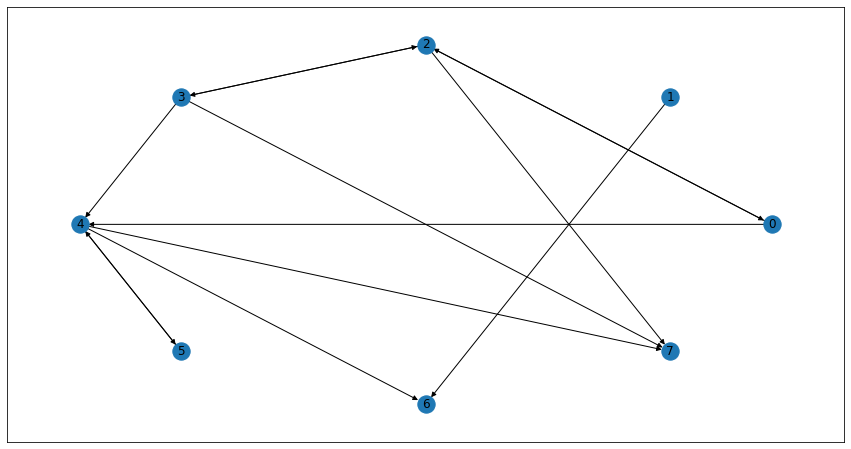

In [9]:
Orient_edges(data,alpha)